# sektor kesehatan masyarakat

Proyek ini akan menganalisa manakah yang lebih baik ketika positif covid. Apakah isolasi mandiri atau dirawat ?

In [1]:
from pandas import read_csv
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression, SelectKBest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


dframe = read_csv('data-rekap-harian-kasus-covid-19-per-kelurahan-di-provinsi-dki-jakarta-bulan-juli-2020 (1).csv')
dframe.head(100)

,id_kel,nama_provinsi,nama_kota,nama_kecamatan,nama_kelurahan,odp,proses_pemantauan,selesai_pemantauan,odp_meninggal,pdp,masih_dirawat,pulang_dan_sehat,pdp_meninggal,positif,dirawat,sembuh,meninggal,self_isolation,keterangan
0,BELUM DIKETAHUI,BELUM DIKETAHUI,BELUM DIKETAHUI,BELUM DIKETAHUI,BELUM DIKETAHUI,13097,2,13036,59,5301,5,3736,1560,1486,221,289,25,951,NaN
1,LUAR DKI JAKARTA,LUAR DKI JAKARTA,LUAR DKI JAKARTA,LUAR DKI JAKARTA,LUAR DKI JAKARTA,13869,260,13597,12,3378,178,3122,78,1907,27,1720,75,85,NaN
2,3173061005,DKI JAKARTA,JAKARTA BARAT,KALI DERES,PEGADUNGAN,588,6,581,1,83,4,73,6,53,5,41,4,3,NaN
3,3174071006,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN BARU,SENAYAN,23,0,23,0,18,1,17,0,16,0,16,0,0,NaN
4,3173051001,DKI JAKARTA,JAKARTA BARAT,KEBON JERUK,KEBON JERUK,753,4,748,1,74,4,67,3,76,1,50,7,18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3171051003,DKI JAKARTA,JAKARTA PUSAT,CEMPAKA PUTIH,RAWASARI,464,3,461,0,77,0,75,2,18,2,12,2,2,NaN
96,3173021005,DKI JAKARTA,JAKARTA BARAT,GROGOL PETAMBURAN,TANJUNG DUREN SELATAN,227,1,226,0,30,4,25,1,41,1,26,5,9,NaN
97,3175031002,DKI JAKARTA,JAKARTA TIMUR,JATINEGARA,BIDARA CINA,111,1,110,0,10,0,8,2,51,4,23,7,17,NaN
98,3174021002,DKI JAKARTA,JAKARTA SELATAN,SETIA BUDI,KARET SEMANGGI,61,0,61,0,15,0,14,1,5,0,3,2,0,NaN


# Data Cleaning  

Dataset tersebut mempunyai banyak variabael. Saya hanya membutuhkan variabel yang menjelaskan tentang “dirawat”, “self_isolation” sebagai input dan “ sembuh” sebagai output. Variabel selain itu, dihapus.



In [2]:
data_frame = dframe.drop(dframe.columns[[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,16,18]], axis=1)
data_frame

,dirawat,sembuh,self_isolation
0,221,289,951
1,27,1720,85
2,5,41,3
3,0,16,0
4,1,50,18
...,...,...,...
264,0,10,2
265,0,1,1
266,0,2,2
267,0,2,3


In [3]:
#memberi tanda (marking) pada data yang hilang
num_missing = (data_frame[["dirawat","sembuh","self_isolation"]] == 0).sum()
print(num_missing)

dirawat           68
sembuh             5
self_isolation    25
dtype: int64


terlihat bahwa setiap data nya ada yang bernilai nol. 
Ini memungkinkan untuk kolom tersebut bernilai nol. jadi, saya akan membiarkan nilai nol tersebut. 

In [4]:
data_kosong= data_frame.isnull().values.any().sum()
print("data kosong :", data_kosong)

data kosong : 0


data yang kosong juga tidak ada. Maka, tidak ada yang perlu dikawatirkan.

#### cek outlier

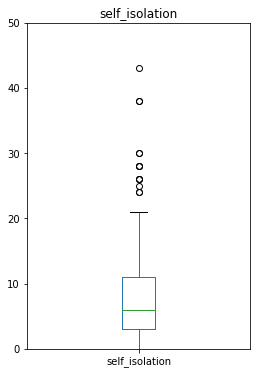

In [5]:
#sembuh
data_frame['self_isolation'].plot(kind='box',figsize=(4,6))
plt.title("self_isolation")
plt.ylim(0,50)
plt.show()

Berdasarkan pengaturan default pandas boxplot (1,5 * IQR), kita dapat melihat bahwa ada beberapa sampel yang dianggap sebagai outlier.

Saya ingin membandingkan karakteristik pasien yang dianggap outlier atas dan bukan.

In [6]:
IQR = data_frame['self_isolation'].quantile(.75) - data_frame['self_isolation'].quantile(.25)
df_upper_outliers = data_frame[data_frame['self_isolation'] > 1.5 * IQR + data_frame['self_isolation'].quantile(.75)]
df_normal= data_frame[data_frame['self_isolation'] <= 1.5 * IQR + data_frame['self_isolation'].quantile(.75)]


In [7]:
df_upper_outliers.describe()

,dirawat,sembuh,self_isolation
count,20.000000,20.000000,20.000000
mean,16.850000,134.650000,86.550000
std,48.477097,378.098744,204.602689
min,0.000000,6.000000,24.000000
25%,3.000000,24.750000,26.000000
50%,4.000000,31.500000,30.000000
75%,5.250000,54.000000,55.250000
max,221.000000,1720.000000,951.000000


In [8]:
df_normal.describe()

,dirawat,sembuh,self_isolation
count,249.000000,249.000000,249.000000
mean,1.875502,16.779116,6.526104
std,2.107150,15.928881,5.048187
min,0.000000,0.000000,0.000000
25%,0.000000,7.000000,3.000000
50%,1.000000,13.000000,5.000000
75%,3.000000,22.000000,9.000000
max,12.000000,140.000000,21.000000


- Mean `sembuh`       : 134.65 vs 16.77
- Mean `dirawat`         : 16.85 vs 1.87
- Mean `self_isolation`  : 86.55 vs 6.52


Jelas bahwa sampel yang dianggap outlier berdasarkan self_isolation memiliki sebaran data yang sangat berbeda dengan sampel yang dianggap normal. Jadi, kita jelas tidak bisa menghilangkan outlier ini.

# seleksi fitur

#### Feature Selection using Anova

In [9]:
X = data_frame.drop(labels=["sembuh"],axis=1) # Features
y = data_frame["sembuh"] # Target

print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(269, 2)
(269,)


In [10]:

"""
f_regression()
Univariate linear regression tests.

Linear model for testing the individual effect of each of many regressors.
This is a scoring function to be used in a feature selection procedure, not
a free standing feature selection procedure.

This is done in 2 steps:

1. The correlation between each regressor and the target is computed,
   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
   std(y)).
2. It is converted to an F score then to a p-value.
""" 


'\nf_regression()\nUnivariate linear regression tests.\n\nLinear model for testing the individual effect of each of many regressors.\nThis is a scoring function to be used in a feature selection procedure, not\na free standing feature selection procedure.\n\nThis is done in 2 steps:\n\n1. The correlation between each regressor and the target is computed,\n   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *\n   std(y)).\n2. It is converted to an F score then to a p-value.\n'

In [11]:
# apply SelectKBest class to extract top 3 best features
fs = SelectKBest(score_func=f_regression,k=2) ## Select k as per your business understaing
# Apply feature selection
fit = fs.fit(X,y)

In [12]:
print(np.round(fit.pvalues_,4))
print(np.round(fit.scores_,3))

[0.     0.0001]
[21.298 16.057]


In [13]:
features_score = pd.DataFrame(fit.scores_)
features_pvalue = pd.DataFrame(np.round(fit.pvalues_,4))
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features,features_score,features_pvalue],axis=1)
# Assign the column name
feature_score.columns = ["Input_Features","F_Score","P_Value"]
print(feature_score.nlargest(3,columns="F_Score"))

   Input_Features    F_Score  P_Value
0         dirawat  21.297618   0.0000
1  self_isolation  16.057060   0.0001


Dengan metode anova, terlihat bahwa fitur yang paling berhubungan dengan output ("sembuh") adalah "dirawat"

#### Feature Selection using Mutual Imputation

In [14]:
### Train test split to avoid overfitting
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data_frame.drop(labels=['sembuh'], axis=1),
    data_frame['sembuh'],
    test_size=0.3,
    random_state=0)

In [15]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.25574667, 0.12521694])

In [16]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

dirawat           0.255747
self_isolation    0.125217
dtype: float64

Nilai yang lebih tinggi berarti ketergantungan lebih tinggi

<function matplotlib.pyplot.show(close=None, block=None)>

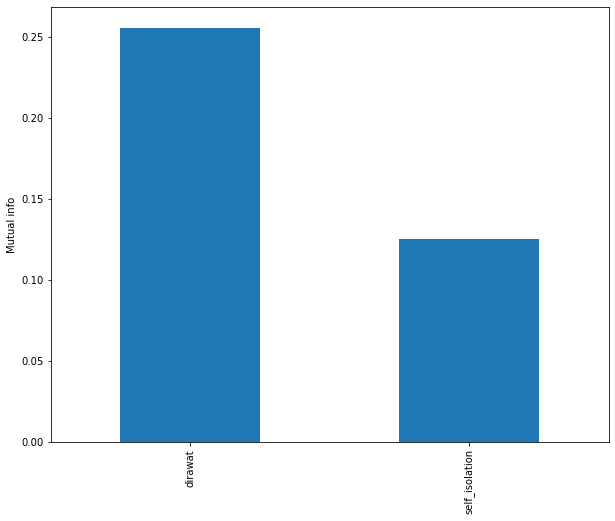

In [19]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 8))
plt.ylabel('Mutual info', size=10)
plt.show

## Kesimpulan
Jadi, berdasarkan proses di atas, maka dapat disimpulkan bahwa  tindakan yang paling baik ketika positif covid adalah "dirawat"